In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score

# Loading the dataset

In [2]:
import os
import gzip

In [3]:
def load_fmnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [4]:
X_train, y_train = load_fmnist('Weights/fashion/', kind='train')
X_test, y_test = load_fmnist('Weights/fashion/', kind='t10k')

In [5]:
X_train = X_train.copy()
y_train = y_train.copy()
X_test = X_test.copy()
y_test = y_test.copy()

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


# Preprocessing

## Pruning the dataset

In [7]:
X_train = X_train[np.logical_or(y_train == 1, y_train == 2)]
y_train = y_train[np.logical_or(y_train == 1, y_train == 2)]
X_test = X_test[np.logical_or(y_test == 1, y_test == 2)]
y_test = y_test[np.logical_or(y_test == 1, y_test == 2)]

In [8]:
y_train = y_train - 1
y_test = y_test - 1

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12000, 784), (12000,), (2000, 784), (2000,))

## Binarizing the dataset

In [10]:
plt.style.use('seaborn')
plt.style.use('ggplot')
plt.style.use('dark_background')

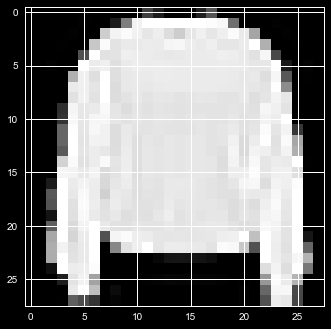

In [11]:
plt.imshow(X_train[1].reshape(28, 28), cmap='gray')
plt.savefig('plots/Q3_image_before_binarizing.png')
plt.show()

In [12]:
for i in tqdm(range(len(X_train))):
    X_train[i] = X_train[i] > 128
    X_train[i] = X_train[i]*255

100%|██████████| 12000/12000 [00:00<00:00, 84223.39it/s]


In [13]:
for i in tqdm(range(len(X_test))):
    X_test[i] = X_test[i] > 128
    X_test[i] = X_test[i]*255


100%|██████████| 2000/2000 [00:00<00:00, 51444.60it/s]


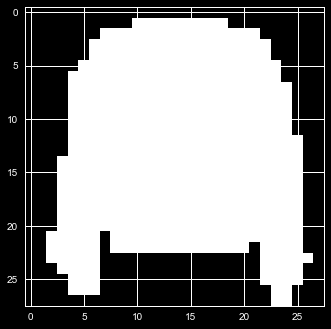

In [14]:
plt.imshow(X_train[1].reshape(28, 28), cmap='gray')
plt.savefig('plots/Q3_image_after_binarizing.png')
plt.show()

In [15]:
np.unique(y_train)

array([0, 1], dtype=uint8)

# Naïve Bayes

## Calculating prior probabilities and conditional probabilities

In [16]:
def priorProb(y, label):
    '''
    Returns the prior probability of a given label
    :param y: the label vector
    :param label: the label
    :return: the prior probability
    '''
    totalExamples = y.shape[0]
    classExamples = np.sum(y == label)
    return classExamples/float(totalExamples)

In [17]:
def conditional_prob(X_train, y_train, label, featureName, featureValue):
    '''
    Returns the conditional probability of a feature given a label
    :param X_train: the training data
    :param y_train: the training labels
    :param label: the label
    :param featureName: the name of the feature
    :param featureValue: the value of the feature
    :return: the conditional probability of the feature given the label
    '''
    X_filtered = X_train[y_train == label]
    numerator = np.sum(X_filtered[:, featureName] == featureValue)
    denominator = np.sum(y_train == label)
    return (numerator + 1) / (float(denominator) + 2)

In [18]:
def trainModel(X_train, y_train):
    '''
    Trains a model using the training data
    :param X_train: the training data
    :param y_train: the training labels
    :return: priorProbabilities of the classes and the conditional probability of all the scenarios
    '''
    n_features = X_train.shape[1]
    classes = np.unique(y_train)
    n_classes = len(classes)
    # Getting the class prior probabilities
    classProb = np.zeros(n_classes)
    for label in classes:
        classProb[int(label)] = priorProb(y_train, label)
    featureVals = np.array([0,255])
    n_featureVals = len(featureVals)
    condProb = np.zeros((n_classes, n_features, n_featureVals))
    # getting the conditional probabilities
    for label in classes:
        for feature in range(n_features):
            for featureValue in featureVals:
                condProb[int(label), int(feature), int(featureValue//255)] = conditional_prob(X_train, y_train, label, feature, featureValue)
    return classProb, condProb


In [19]:
def predict(X_train, y_train, x_test, condProb, classProb):
    '''
    Predicts the labels of the test data
    :param X_train: the training data
    :param y_train: the training labels
    :param x_test: the test data
    :param condProb: the conditional probability of all the scenarios
    :param classProb: the prior probability of the classes
    :return: the predicted labels
    '''
    # x_test is a single testing point with n features
    n_features = X_train.shape[1]
    classes = np.unique(y_train)
    posteriorProb = []
    # Compute posterior probabilities for each class
    for label in classes:
        likelihood = 1.0
        for feature in range(n_features):
            conditional_prob = condProb[int(label), int(feature), int(x_test[feature]//255)]
            likelihood *= conditional_prob
        prior_prob = classProb[int(label)]
        prob = likelihood * prior_prob
        posteriorProb.append(prob)
    pred = np.argmax(posteriorProb)
    return pred

In [20]:
def score(X_train, y_train, X_test, y_test, condProb, classProb):
    '''
    Computes the accuracy of the model
    :param X_train: the training data
    :param y_train: the training labels
    :param X_test: the test data
    :param y_test: the test labels
    :param condProb: the conditional probability of all the scenarios
    :param classProb: the prior probability of the classes
    :return: the accuracy over the test data
    '''
    pred = []
    for i in tqdm(range(X_test.shape[0])):
        pred.append(predict(X_train, y_train, X_test[i], condProb, classProb))
    pred = np.array(pred)
    accuracy = np.sum(pred == y_test) / float(y_test.shape[0])
    return accuracy*100

In [26]:
def printROC(X_train, y_train, X_test, y_test, condProb, classProb):
    pred = []
    for i in tqdm(range(X_test.shape[0])):
        pred.append(predict(X_train, y_train, X_test[i], condProb, classProb))
    pred = np.array(pred)
    fpt, tpt, thr = roc_curve(y_test, pred)
    plt.plot(fpt, tpt)
    print(roc_auc_score(y_test, pred))


In [23]:
# Training the model
classProb, conditionalProb = trainModel(X_train, y_train)

100%|██████████| 2000/2000 [00:18<00:00, 110.90it/s]


0.9315


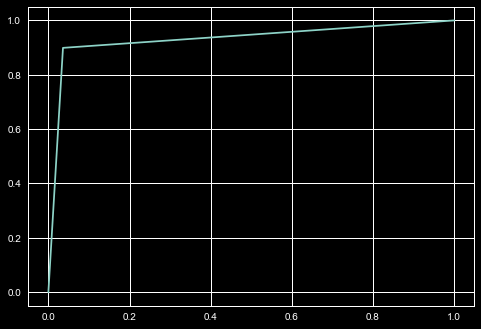

In [27]:
printROC(X_train, y_train, X_test, y_test, conditionalProb, classProb)

In [30]:
# Getting the accuracy on test set
print(score(X_train, y_train, X_test, y_test, conditionalProb, classProb))

100%|██████████| 2000/2000 [00:19<00:00, 105.05it/s]

93.15


# K-Fold cross validation

In [31]:
K = 5

In [32]:
X_train.shape, y_train.shape

((12000, 784), (12000,))

In [33]:
fullTrainData = np.hstack((X_train, y_train.reshape(-1, 1)))

In [34]:
fullTrainData.shape, X_train.shape, y_train.shape

((12000, 785), (12000, 784), (12000,))

In [35]:
type(fullTrainData)

numpy.ndarray

In [36]:
np.random.shuffle(fullTrainData)

In [37]:
batchSize = fullTrainData.shape[0] // K
batchSize

2400

In [38]:
X_train_k = []
y_train_k = []
for i in range(K):
    tempTrain = fullTrainData[i*batchSize:(i+1)*batchSize, :-1]
    tempTest = fullTrainData[i*batchSize:(i+1)*batchSize, -1]
    X_train_k.append(tempTrain)
    y_train_k.append(tempTest)

In [39]:
X_train_k[0].shape, y_train_k[0].shape

((2400, 784), (2400,))

In [40]:
len(X_train_k)

5

In [41]:
type(y_train)

numpy.ndarray

In [42]:
validationAccuracies = []
testAccuracies = []
for i in range(K):
    temp_x_test = X_train_k[i]
    temp_y_test = y_train_k[i]
    temp_x_train = np.vstack(X_train_k[:i] + X_train_k[i+1:])
    temp_y_train = np.empty((0,))
    for j in range(K):
        if j!=i:
            temp_y_train = np.concatenate((temp_y_train, y_train_k[j]), axis=0)
    temp_y_train = np.array(temp_y_train)
    classProb, conditionalProb = trainModel(temp_x_train, temp_y_train)
    validationAccuracy = score(temp_x_train, temp_y_train, temp_x_test, temp_y_test, conditionalProb, classProb)
    testAccuracy = score(temp_x_train, temp_y_train, X_test, y_test, conditionalProb, classProb)
    print(str(i) + ' validation ' + str(validationAccuracy))
    print(str(i) + ' test :' + str(testAccuracy) )
    validationAccuracies.append(validationAccuracy)
    testAccuracies.append(testAccuracy)


100%|██████████| 2000/2000 [00:18<00:00, 107.97it/s]


0 validation 92.33333333333333
0 test :93.10000000000001


100%|██████████| 2000/2000 [00:18<00:00, 106.78it/s]


1 validation 93.375
1 test :93.30000000000001


100%|██████████| 2000/2000 [00:17<00:00, 114.27it/s]


2 validation 92.95833333333333
2 test :93.30000000000001


100%|██████████| 2000/2000 [00:27<00:00, 74.07it/s]


3 validation 92.625
3 test :93.10000000000001


100%|██████████| 2000/2000 [00:26<00:00, 76.69it/s] 

4 validation 93.66666666666667
4 test :93.15


In [43]:
avgValidation = sum(validationAccuracies) / float(len(validationAccuracies))
avgTest = sum(testAccuracies) / float(len(testAccuracies))

In [44]:
print('Average validation accuracy: ' + str(avgValidation))
print('Average test accuracy: ' + str(avgTest))

Average validation accuracy: 92.99166666666666
Average test accuracy: 93.19000000000001


# Confusion Matrix and ROC Curve

In [53]:
def getConfusionMatrix(X_train, y_train, X_test, y_test):  
    '''
    Computes the confusion matrix, Accuracy, Precision, Recall and F1 score
    :param X_train: the training data
    :param y_train: the training labels
    :param X_test: the test data
    :param y_test: the test labels
    :return: None
    '''
    # training the model
    classProb, condProb = trainModel(X_train, y_train)

    # getting predictions
    pred = []
    for i in tqdm(range(X_test.shape[0])):
        pred.append(predict(X_train, y_train, X_test[i], condProb, classProb))
    y_ = np.array(pred)

    # computing confusion matrix
    confusionMatrix = np.zeros((2, 2))
    for i in range(y_test.shape[0]):
        confusionMatrix[int(y_test[i]), int(y_[i])] += 1

    # computing accuracy, precision, recall and f1 score
    accuracy = (confusionMatrix[0, 0] +
                confusionMatrix[1, 1]) / np.sum(confusionMatrix)
    precision = (confusionMatrix[1, 1]) / confusionMatrix[:, 1].sum()
    recall = (confusionMatrix[1, 1]) / confusionMatrix[1, :].sum()
    f1 = 2 * precision * recall / (precision + recall)
    print(confusionMatrix)
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F1: ' + str(f1))


In [54]:
# Confusion matrix of the format: 
# [[(actual 0 and predicted 0), (actual 0 and predicted 1)],
#  [(actual 1 and predicted 0), (actual 1 and predicted 1)]]
getConfusionMatrix(X_train, y_train, X_test, y_test)

100%|██████████| 2000/2000 [00:17<00:00, 113.70it/s]

[[964.  36.]
 [101. 899.]]
Accuracy: 0.9315
Precision: 0.9614973262032086
Recall: 0.899
F1: 0.9291989664082687


In [28]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, auc

In [29]:
bnb = BernoulliNB()

In [30]:
bnb.fit(X_train, y_train)
y_bnb_score = bnb.predict_proba(X_test)

In [35]:
print(bnb.score(X_test, y_test))

0.932


In [31]:
fpr_bnb, tpr_bnb, _ = roc_curve(y_test, y_bnb_score[:, 1])

0.97709


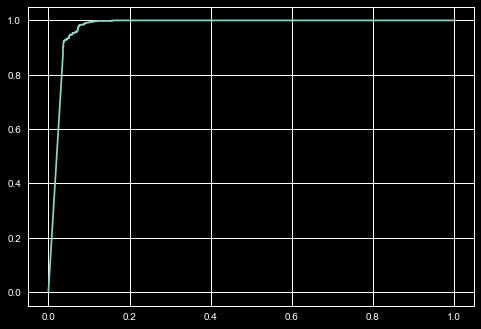

In [34]:
plt.plot(fpr_bnb, tpr_bnb)
print(roc_auc_score(y_test, y_bnb_score[:, 1]))
# print(roc_auc_score(y_test, pred))

In [36]:
y_bnb_score[:10]

array([[5.92856496e-302, 1.00000000e+000],
       [1.00000000e+000, 1.67904714e-121],
       [1.00000000e+000, 9.81011624e-114],
       [1.00000000e+000, 2.46830506e-079],
       [1.00000000e+000, 8.32767462e-099],
       [3.31541459e-049, 1.00000000e+000],
       [0.00000000e+000, 1.00000000e+000],
       [1.00000000e+000, 9.41525412e-130],
       [1.00000000e+000, 1.10688246e-110],
       [2.73493633e-305, 1.00000000e+000]])

In [39]:
pred = []
classProb, condProb = trainModel(X_train, y_train)

for i in tqdm(range(X_test.shape[0])):
    pred.append(predict(X_train, y_train, X_test[i], condProb, classProb))
    y_ = np.array(pred)


100%|██████████| 2000/2000 [00:25<00:00, 78.75it/s] 
